In [9]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [10]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

from general_utils import AttrDict, make_image_seq_strip
from reward_induced.src.reward_predictor_model import RewardPredictorModel
from reward_induced.src.image_decoder import ImageDecoder
from sprites_datagen.moving_sprites import MovingSpriteDataset, TemplateMovingSpritesGenerator
from sprites_datagen.rewards import *

from tqdm import trange
import matplotlib.pyplot as plt
import cv2

In [11]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 10  # number of conditioning frames
T_future = 20  # number of future frames to predict rewards for

lr = 1e-3
n_iter = 2_000
log_interval = 500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[ZeroReward],
    )

dataset = MovingSpriteDataset(spec)

# **STEP 1: Define an ImageDecoder trainer**

- GOAL: reconstruct the original images
  - encoder: complete images -> reward-induced representation
  - decoder: reward-induced representation -> complete images

In [13]:
def train_decoder(encoder, decoder, dataset, device, n_iter):
    # decoder should restore the original image from the reward-induced representation
    loss_fn = nn.MSELoss()
    optimizer = RAdam(decoder.parameters(), lr=lr)

    losses = []
    print(f'[INFO] Train decoder on device: {device} ...')

    for itr in trange(n_iter):
        data = dataset[itr]
        images = torch.tensor(data.images).to(device)
		
        # encode the images
        with torch.no_grad():
            encoded_repr = encoder(images).detach()
        
        # decode the images
        decoded_images = decoder(encoded_repr)

        loss = loss_fn(decoded_images, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (itr+1) % log_interval == 0:
            print(f'[{itr+1} / {n_iter}] Reproduction loss: {loss.item()}')

    return losses

# **STEP 2: Decode the reward-induced representation**

- GOAL: decode the reward-induced representation to subset of images
  - (1) VertPosReward
    - Train RPM with VertPosReward
    - Decode the reward-induced representation with detached decoder (from STEP 1)
  - (2) HorzPosReward
    - Train RPM with HorzPosReward
    - Decode the reward-induced representation with detached decoder (from STEP 1)

###

In [14]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=1,      # number of shapes per trajectory
        rewards=[VertPosReward, HorPosReward],
    )

generator = TemplateMovingSpritesGenerator(spec)
generator.SHAPES = ['tri_bottom']

In [15]:
output = generator.gen_trajectory()
images = make_image_seq_strip([output['images'][None, :, None].repeat(3, axis=2).astype(np.float32)], \
                              sep_val=255.0).astype(np.uint8)


print(f'images shape: {output.images.shape}, max: {output.images.max()}, min: {output.images.min()}')
cv2.imwrite('imgs/one_distractor.png', images[0].transpose(1, 2, 0))

print(output['rewards'])

images shape: (30, 64, 64), max: 255, min: 0
{'vertical_position': array([0.23094916, 0.18920824, 0.14746732, 0.1057264 , 0.13601452,
       0.17775545, 0.21949637, 0.2612373 , 0.30297822, 0.3447191 ,
       0.38646004, 0.42820096, 0.46994188, 0.5116828 , 0.5534237 ,
       0.59516466, 0.63690555, 0.6786465 , 0.7203874 , 0.76212835,
       0.80386925, 0.8456102 , 0.8873511 , 0.87090796, 0.82916707,
       0.7874261 , 0.7456852 , 0.7039443 , 0.6622034 , 0.6204625 ],
      dtype=float32), 'horizontal_position': array([0.6271969 , 0.602496  , 0.57779515, 0.5530943 , 0.52839345,
       0.5036926 , 0.47899175, 0.4542909 , 0.42959002, 0.40488917,
       0.38018832, 0.35548747, 0.33078662, 0.30608577, 0.2813849 ,
       0.25668404, 0.23198318, 0.20728232, 0.18258147, 0.15788062,
       0.13317975, 0.1084789 , 0.11622195, 0.14092281, 0.16562366,
       0.19032452, 0.21502538, 0.23972623, 0.2644271 , 0.28912795],
      dtype=float32)}


## Decode vertical reward-induced representations with ImageDecoder

In [16]:
model_vertical = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
decoder_vertical = ImageDecoder(image_shape).to(device)

In [17]:
def train_RPM_single_reward(model, generator, device, reward_type_list: list[str]):
	loss_fn = nn.MSELoss()
	optimizer = RAdam(model.parameters(), lr=lr)
	
	losses = []
	print(f'[INFO] Train RPM with {reward_type_list} reward on device: {device} ...')

	for itr in trange(n_iter):
		traj = generator.gen_trajectory()
		images = traj.images[:, None].repeat(3, axis=1).astype(np.float32) / (255./2) - 1.0
		images = torch.tensor(images).to(device)
		rewards = {k: torch.tensor(v, dtype=torch.float32, device=device) for k, v in traj.rewards.items()}
		
		# assume n_frames + T_future == len(images)
		pred_rewards, _ = model(
			frames=images,
			reward_type_list=reward_type_list
		)

		# compute loss for each reward type
		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = rewards[reward_type][-T_future:]
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [18]:
losses = train_RPM_single_reward(model_vertical, generator, device, ['vertical_position'])

[INFO] Train RPM with ['vertical_position'] reward on device: cuda ...


 25%|██▌       | 508/2000 [00:09<00:28, 52.25it/s]

[500 / 2000] RPM loss: 0.0891660824418068


 50%|█████     | 1007/2000 [00:19<00:21, 47.00it/s]

[1000 / 2000] RPM loss: 9.386863530380651e-05


 75%|███████▌  | 1504/2000 [00:28<00:09, 50.88it/s]

[1500 / 2000] RPM loss: 6.195167952682823e-05


100%|██████████| 2000/2000 [00:37<00:00, 52.81it/s]

[2000 / 2000] RPM loss: 0.0006637921906076372


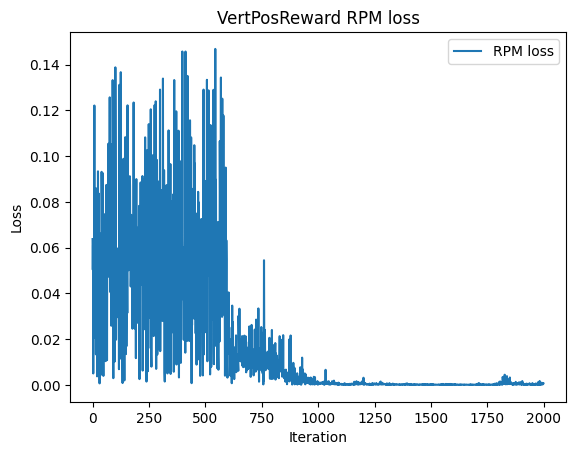

In [19]:
# Visualize the losses
plt.plot(losses, label='RPM loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('VertPosReward RPM loss')
plt.legend()
plt.show()

## Decode horizontal reward-induced representations with ImageDecoder

In [20]:
losses_decoder = train_decoder(model_vertical, decoder_vertical, dataset, device, n_iter)

[INFO] Train decoder on device: cuda ...


 26%|██▌       | 511/2000 [00:08<00:25, 59.44it/s]

[500 / 2000] Reproduction loss: 0.24412338435649872


 50%|█████     | 1006/2000 [00:16<00:16, 59.66it/s]

[1000 / 2000] Reproduction loss: 0.18649958074092865


 75%|███████▌  | 1508/2000 [00:25<00:08, 60.40it/s]

[1500 / 2000] Reproduction loss: 0.21837450563907623


100%|██████████| 2000/2000 [00:33<00:00, 59.50it/s]

[2000 / 2000] Reproduction loss: 0.19765658676624298


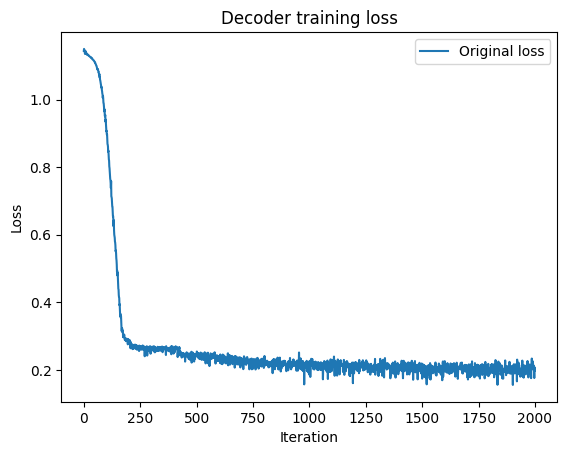

In [21]:
# Visualize the losses
plt.plot(losses_decoder, label='Original loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [22]:
DECODER_PATH = 'models/vertical_decoder_tanh_2K.pth'
torch.save(decoder_vertical.state_dict(), DECODER_PATH)

## Test Vertical Position Reward finetuned RPM with detached decoder

In [23]:
# Save original image
output = generator.gen_trajectory()
original_images = make_image_seq_strip([output['images'][None, :, None].repeat(3, axis=2).astype(np.float32)], \
                              sep_val=255.0).astype(np.uint8)
cv2.imwrite('imgs/vertical_original_image.png', original_images[0].transpose(1, 2, 0))

True

In [26]:
images = output['images'][:, None].repeat(3, axis=1).astype(np.float32) / (255./2) - 1.0
images = torch.tensor(images).to(device)

decoder_vertical.to(device).eval()

with torch.no_grad():
    encoded_repr = model_vertical.image_encoder(images)
    decoded_images = decoder_vertical(encoded_repr)

decoded_images = (decoded_images.cpu().numpy() + 1) * (255./2)
print(f'decoded images shape: {decoded_images.shape}, max: {decoded_images.max()}, min: {decoded_images.min()}')

decoded_images = make_image_seq_strip([decoded_images[None, :].astype(np.float32)], sep_val=255.0).astype(np.uint8)
cv2.imwrite('imgs/vertical_decoded.png', decoded_images[0].transpose(1, 2, 0))

decoded images shape: (30, 3, 64, 64), max: 154.10586547851562, min: 0.34118369221687317


True

## [TEMP] Test decoder trainer with complete RPM

In [28]:
model = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
model.load_state_dict(torch.load('models/complete_RPM_1e-3_1M.pth'))

decoder = ImageDecoder(image_shape).to(device)

In [29]:
losses = train_decoder(model, decoder, dataset, device, n_iter)

[INFO] Train decoder on device: cuda ...


 26%|██▌       | 510/2000 [00:07<00:20, 70.95it/s]

[500 / 2000] Reproduction loss: 0.24408870935440063


 51%|█████     | 1011/2000 [00:15<00:14, 68.50it/s]

[1000 / 2000] Reproduction loss: 0.22931459546089172


 75%|███████▌  | 1509/2000 [00:23<00:10, 45.45it/s]

[1500 / 2000] Reproduction loss: 0.17368416488170624


100%|██████████| 2000/2000 [00:31<00:00, 63.64it/s]

[2000 / 2000] Reproduction loss: 0.16984038054943085


In [30]:
output = generator.gen_trajectory()
images = output['images'][:, None].repeat(3, axis=1).astype(np.float32) / (255./2) - 1.0
images = torch.tensor(images).to(device)

decoder.to(device).eval()

with torch.no_grad():
    encoded_repr = model.image_encoder(images)
    decoded_images = decoder(encoded_repr)

decoded_images = (decoded_images.cpu().numpy() + 1) * (255./2)
print(f'decoded images shape: {decoded_images.shape}, max: {decoded_images.max()}, min: {decoded_images.min()}')

decoded_images = make_image_seq_strip([decoded_images[None, :].astype(np.float32)], sep_val=255.0).astype(np.uint8)
cv2.imwrite('imgs/complete_decoded.png', decoded_images[0].transpose(1, 2, 0))

decoded images shape: (30, 3, 64, 64), max: 115.50359344482422, min: 0.0


True

### Decode horizontal reward-induced representations with ImageDecoder